In [125]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.metrics import PredictionErrorDisplay


from jre_utils.datapath import model_ready_data_paths, model_output_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
    EarlyStopper,
)


warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [126]:
metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
    "weighted_mean_smoothed": "unit_price_wmean_smoothed",
    "weighted_median_smoothed": "unit_price_wmedian_smoothed",
    "mean_smoothed": "unit_price_mean_smoothed",
    "median_smoothed": "unit_price_median_smoothed",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]
display_columns = ["unit_price", "total_traded_area", "count"]

metric_key_unsmoothed = "median"
metric_unsmoothed = metrics[metric_key_unsmoothed]

metric_key = f"{metric_key_unsmoothed}_smoothed"
metric = metrics[metric_key]

metric_pct_chg = metric + "_pct_chg"
normalized_metric_pct_chg = metric_pct_chg + "_normalized_yearly"

In [127]:
start_year = 2006
eval_start_year = 2020  # eval_years = [2020, 2021, 2022]
eval_end_year = 2022

dataset_key = "transactions"
years_ahead = 2
dataset_name = f"sequence_{dataset_key}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_ready_data_path = model_ready_data_paths[dataset_name]
model_output_data_path = model_output_data_paths[output_dataset_name]

df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)

# Weighting by count
# df["weight"] = df["count"].apply(lambda x: 1 + np.log10(x))

# Weighting by population
df["weight"] = df.groupby("year")["log_population"].transform(lambda x: x - x.min() + 1)

train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)].reset_index(
    drop=True
)
eval_df = df[df["year"] >= eval_start_year].reset_index(drop=True)

In [128]:
df[df["area_code"] == 1100][["year", "population"]]

,year,population
31,2008,1.867571e+06
685,2009,1.877302e+06
1082,2010,1.886889e+06
3150,2011,1.892177e+06
4365,2012,1.902431e+06
6360,2013,1.911539e+06
6813,2014,1.921627e+06
8702,2015,1.929990e+06
10419,2016,1.938163e+06
11971,2017,1.947300e+06


<Axes: ylabel='Frequency'>

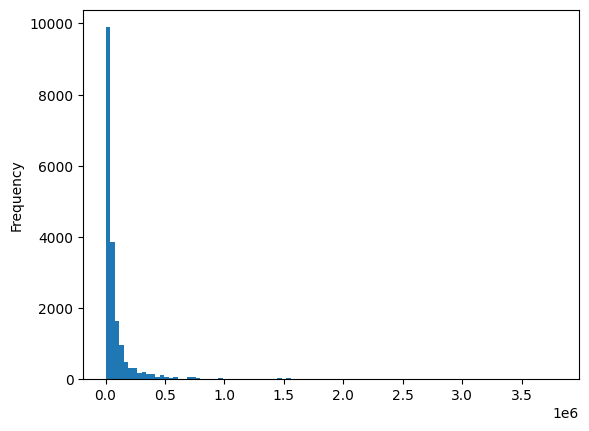

In [129]:
df["population"].plot.hist(bins = 100)

<Axes: ylabel='Frequency'>

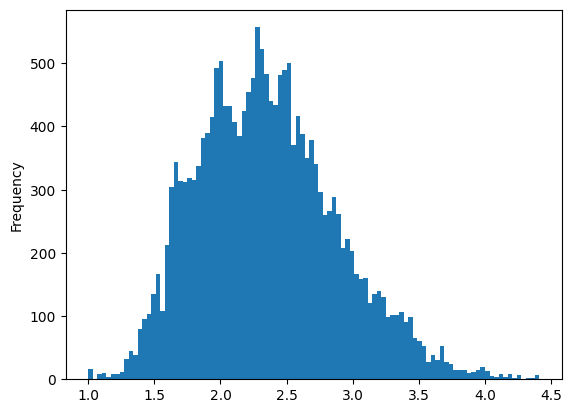

In [132]:
df["weight"].plot.hist(bins = 100)

<Axes: ylabel='Frequency'>

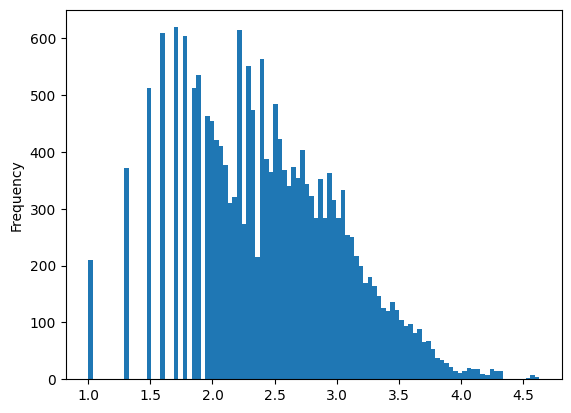

In [134]:
df["count"].apply(lambda x: 1 + np.log10(x)).plot.hist(bins = 100)

In [78]:
train_df[train_df["area_code"] == 13101][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_median_smoothed,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
6,2007,2.204983e+06,0.227171,2.619291
78,2008,2.197454e+06,0.139858,1.066988
724,2009,2.069647e+06,-0.061378,-0.060949
1207,2010,1.825045e+06,-0.169473,-0.456003
2706,2011,1.620211e+06,-0.217156,-0.780465
3820,2012,1.684720e+06,-0.076888,-0.332538
5565,2013,1.947510e+06,0.202010,1.113350
7246,2014,2.130575e+06,0.264646,1.446387
9062,2015,2.257352e+06,0.159097,0.843063
9864,2016,2.645833e+06,0.241840,1.197871


In [79]:
eval_df[eval_df["area_code"] == 13101][["year", metric, metric_pct_chg, normalized_metric_pct_chg]]

,year,unit_price_median_smoothed,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
931,2020,3.849920e+06,0.257623,1.115681
1819,2021,4.164547e+06,0.225359,0.829393
2940,2022,4.462737e+06,0.159177,0.495757


In [80]:
idx = 2940
row = eval_df.iloc[idx]
target = row[normalized_metric_pct_chg]
area_code, year = row["area_code"], row["year"]
window = (
    df[
        (df["area_code"] == area_code)
        & (df["year"] <= year - 2)
    ]
    .sort_values(by="year")
    .tail(5)
)
print(f"Target: {target}")
window

Target: 0.4957566755770115


,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed,unit_price_median,year,years_since_crisis,count,total_traded_area,population,taxpayer_count,taxable_income,taxable_income_per_taxpayer,taxable_income_growth,taxable_income_per_taxpayer_growth,total_tax,total_tax_growth,new_dwellings,existing_dwellings,net_migration_ratio,new_dwellings_ratio,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available,area_code,area,new_dwellings_ratio_normalized_yearly,log_new_dwellings_ratio,log_new_dwellings_ratio_normalized_yearly,unit_price_median_smoothed_log,unit_price_median_smoothed_log_normalized_yearly,count_log,count_log_normalized_yearly,total_traded_area_log,total_traded_area_log_normalized_yearly,population_log,population_log_normalized_yearly,taxpayer_count_log,taxpayer_count_log_normalized_yearly,taxable_income_log,taxable_income_log_normalized_yearly,taxable_income_per_taxpayer_log,taxable_income_per_taxpayer_log_normalized_yearly,total_tax_log,total_tax_log_normalized_yearly,new_dwellings_log,new_dwellings_log_normalized_yearly,existing_dwellings_log,existing_dwellings_log_normalized_yearly,unit_price_median_smoothed_pct_chg_normalized_yearly,total_tax_growth_normalized_yearly,taxable_income_growth_normalized_yearly,taxable_income_per_taxpayer_growth_normalized_yearly,net_migration_ratio_normalized_yearly,weight
9864,0.241840,2.645833e+06,2.645833e+06,2016,8,58.0,9205.0,60870.0,34324.0,314359478.0,9158.591015,0.123044,0.079495,18441614.0,0.057706,1545.0,38740.0,0.014473,0.039881,1,1,1,1,13101,Tokyo-to Chiyoda-ku,3.656181,0.016984,3.636822,6.422563,3.774303,1.770852,0.510211,3.964071,0.037910,4.784410,0.380982,4.535611,0.579325,8.497427,1.416775,3.961876,7.517390,7.265799,1.001951,3.189209,0.954328,4.588171,0.043614,1.197871,1.241271,3.326466,2.794484,2.891238,2.584374
10708,0.264897,2.855318e+06,3.937500e+06,2017,9,48.0,7930.0,61751.0,35326.0,333664476.0,9445.294571,0.061411,0.031304,19084096.0,0.034839,1415.0,40285.0,0.017522,0.035125,1,1,1,1,13101,Tokyo-to Chiyoda-ku,3.723002,0.014993,3.695703,6.455655,3.798470,1.690196,0.369916,3.899328,-0.096777,4.790651,0.394611,4.548107,0.593019,8.523310,1.445119,3.975261,7.685320,7.280672,1.018779,3.151063,0.915995,4.605154,0.069859,1.325756,0.600038,1.078699,0.662914,3.529738,2.602278
13129,0.157014,3.061267e+06,3.061189e+06,2018,10,50.0,8190.0,62833.0,36299.0,362690825.0,9991.758037,0.086993,0.057856,19816187.0,0.038361,978.0,41700.0,0.032212,0.023453,1,1,1,1,13101,Tokyo-to Chiyoda-ku,1.645595,0.010068,1.648743,6.485901,3.808848,1.707570,0.413483,3.913337,-0.034547,4.798195,0.410681,4.559907,0.607833,8.559537,1.490338,3.999685,7.907294,7.297020,1.035598,2.990783,0.622513,4.620146,0.092986,0.792784,0.767497,1.386379,1.047246,6.184275,2.612646
14004,0.190282,3.398634e+06,3.369318e+06,2019,0,48.0,8015.0,64857.0,38175.0,412894018.0,10815.822344,0.138419,0.082474,21648748.0,0.092478,787.0,42487.0,0.028108,0.018523,1,1,1,1,13101,Tokyo-to Chiyoda-ku,1.240900,0.007971,1.243726,6.531305,3.852786,1.690196,0.393090,3.903958,-0.052881,4.811964,0.438646,4.581790,0.641626,8.615839,1.569186,4.034100,8.219588,7.335433,1.092918,2.896526,0.505207,4.628266,0.099675,0.999511,2.562201,3.300568,2.262774,5.265364,2.631258
15664,0.257623,3.849920e+06,3.787942e+06,2020,1,30.0,3550.0,66680.0,39873.0,400984266.0,10056.536152,-0.028845,-0.070201,20573851.0,-0.049652,1159.0,43646.0,0.014607,0.026555,1,1,1,1,13101,Tokyo-to Chiyoda-ku,3.489141,0.011382,3.469871,6.585452,3.896313,1.491362,-0.028520,3.550351,-0.789306,4.824002,0.463484,4.600690,0.672549,8.603127,1.539504,4.002492,7.945814,7.313316,1.061534,3.064458,0.883396,4.639954,0.116198,1.115681,-1.299834,-1.113892,-2.871377,3.201692,2.647326


In [81]:
log_normalize_columns = [
    metric,
    "count",
    "total_traded_area",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "total_tax",
    "new_dwellings",
    "existing_dwellings",
]

normalize_columns = [
    metric_pct_chg,
    "total_tax_growth",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
]

# log_normalize_columns = []

# normalize_columns = [
#     metric,
#     metric_pct_chg,
#     "count",
#     "total_traded_area",
#     "population",
#     "taxpayer_count",
#     "taxable_income",
#     "taxable_income_per_taxpayer",
#     "taxable_income_growth",
#     "taxable_income_per_taxpayer_growth",
#     "new_dwellings",
#     "existing_dwellings",
#     "new_dwellings_ratio",
#     "net_migration_ratio",
#     "total_tax",
#     "total_tax_growth",
# ]

maintain_columns = [
    metric_pct_chg,
    # "years_since_crisis",
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
]

id_columns = [
    "area_code",
    "area",
    "year",
]

feature_columns = (
    [f"{column}_log_normalized_yearly" for column in log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in normalize_columns]
    + maintain_columns
)

final_columns = id_columns + feature_columns

In [82]:
time_series_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    feature_columns=feature_columns,
    shift=years_ahead
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    shift=years_ahead
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (0, 21) (1,) [-0.21269522] [1.86318684]
1 (0, 21) (1,) [-1.03503937] [1.]
2 (0, 21) (1,) [0.00635028] [2.53601229]
3 (0, 21) (1,) [0.81251324] [2.04566569]
0 torch.Size([5, 21]) torch.Size([1]) tensor([-0.2127]) tensor([1.8632])
1 torch.Size([5, 21]) torch.Size([1]) tensor([-1.0350]) tensor([1.])
2 torch.Size([5, 21]) torch.Size([1]) tensor([0.0064]) tensor([2.5360])
3 torch.Size([5, 21]) torch.Size([1]) tensor([0.8125]) tensor([2.0457])


In [83]:
BATCH_SIZE = 256

In [84]:
train_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
eval_dataset = JapanRETimeSeriesDataset(
    df,
    eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="weight",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

# Building the Transformer Model

In [85]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [86]:
n_features = len(feature_columns)
d_model = 256
d_hid = 256
nlayers = 8
nhead = 8
dropout = 0
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)
model = model.to(device)


In [87]:
model.eval()

mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        
        print("Loss:", loss.item())

        break

torch.Size([256, 5, 21]) torch.Size([256, 5]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 3.1538944244384766


In [88]:
learning_rate = 1e-4 # 3e-4
weight_decay = 1 # 1
num_epochs = 30

In [89]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "linear", # constant
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [90]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train_weighted(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)
    
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: nan, Eval Loss: nan
Train R^2: nan, Eval R^2: nan
Epoch: 1
Train Loss: nan, Eval Loss: nan
Train R^2: nan, Eval R^2: nan


KeyboardInterrupt: 

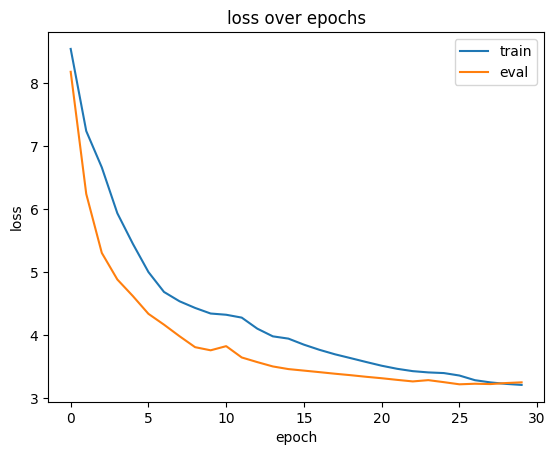

In [56]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

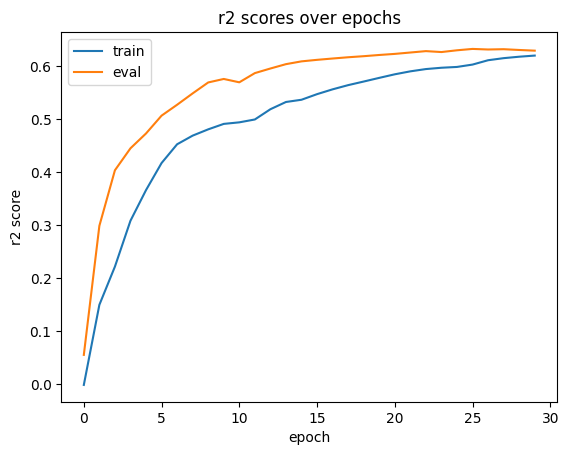

In [57]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

In [58]:
# smoothed model
loss, epoch_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 3.2551
Eval R2: 0.6296


In [59]:
def predict_return(model, area_code, year):
    area_df = df[(df["year"] == year) & (df["area_code"] == area_code)]

    area_dataset = JapanRETimeSeriesDataset(
        df,
        area_df,
        feature_columns=feature_columns,
        metrics=[normalized_metric_pct_chg],
        transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
    )

    area_dataloader = DataLoader(
        area_dataset, batch_size=10, shuffle=False, num_workers=0
    )

    batch = next(iter(area_dataloader))
    
    model.eval()

    output = model(batch["window"].to(device), batch["mask"].to(device))
    return output.item()

In [60]:
years = [2020, 2021, 2022] # saving all predicted years.

prediction_df = df.copy()
prediction_df = prediction_df[prediction_df["year"].isin(years)]
prediction_df["predicted_normalized_return"] = prediction_df.apply(
    lambda row: predict_return(model, row["area_code"], row["year"]), axis=1
)
prediction_df = prediction_df.sort_values(
    by="year", ascending=False
)
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
]

,year,area_code,predicted_normalized_return,unit_price_median_smoothed_pct_chg,unit_price_median_smoothed_pct_chg_normalized_yearly
18825,2022,1581,-0.010626,0.057152,0.141370
17925,2022,8442,0.077870,0.078268,0.214716
17927,2022,18201,-0.020137,-0.021015,-0.130147
17928,2022,21208,-0.874524,-0.232900,-0.866138
17929,2022,19213,-0.277452,0.017118,0.002312
...,...,...,...,...,...
15652,2020,41206,0.733269,0.247609,1.068729
15653,2020,39206,-1.024835,-0.228788,-1.164741
15654,2020,10523,0.768463,0.195643,0.825100
15655,2020,14363,-1.598841,-0.350157,-1.733748


In [62]:
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
].to_csv(model_output_data_path, index=False)

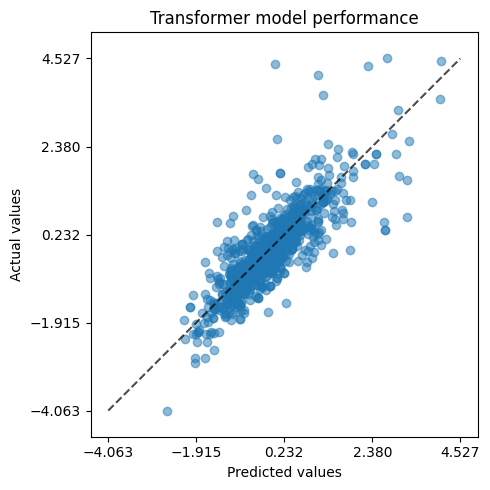

In [63]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

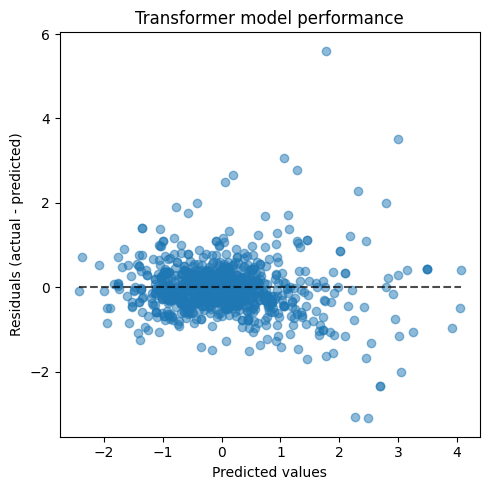

In [66]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="residual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()